In [145]:
import numpy as np
import math


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ,QuantumRegister,ClassicalRegister,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-27 15:55:24,325: Credentials are already in use. The existing account in the session will be replaced.


INPUT : A list containing decimal numbers (positive integers). The expected size of the list is $2^n$ where n belongs to positive integers.

In [204]:
# Enter the integers in the input_array (in decimal)

input_array = [1,5,4,2]

input_size=len(input_array)
address_size=int(math.log(len(input_array),2))
print('Input array has  ',input_size,'elements')
print('Address space size : ',address_size,'bits')

# Input error checking
if(input_size != 2**address_size):
    print("Please consider providing $2^n$ elements for positive integer n.")

Input array has   4 elements
Address space size :  2 bits


In [205]:
#Generate n bit gray code sequence starting with 1111..1111

def get_gray_codes(n):
    
    if n == 0:
        return ['']
    first_half = get_gray_codes(n - 1)
    second_half = first_half.copy()
 
    first_half = ['1' + code for code in first_half]
    second_half = ['0' + code for code in reversed(second_half)]
 
    return first_half + second_half


# Function to convert decimal to binary.
def dec_binary(n):
    return bin(n).replace("0b", "")


print(get_gray_codes(2))

['11', '10', '00', '01']


In [206]:
#Length of the largest binary bitstring in input_array.
bitstring_length = len(dec_binary(max(input_array)))
print("Bitstring(data) size: ",bitstring_length)
# An empty array to store the binary forms of the integers provided as input.
problem_set = []

for num in (input_array):
    # Pad zeros to bring all binary strings to the bitstring_length
    problem_set.append(dec_binary(num).zfill(bitstring_length))
    
print(problem_set)



print ("Input bitstrings are printed below in gray code order")
gray_code_order = get_gray_codes(address_size) # This will be useful to store the numbers in QRAM.
for k in range(input_size):
    cur = gray_code_order[k]
    print ((problem_set[int(str(cur),2)]))

Bitstring(data) size:  3
['001', '101', '100', '010']
Input bitstrings are printed below in gray code order
010
100
001
101


The section below stores the input bitstrings into QRAM. We have used an address register of n bits to store the array of size $2^n$. 
The function qram stores the bitstrings in 'problem_set' into the register 'board'.To minimise the use of Pauli X gates,we have used gray code order for storing the inputs. Two consecutive address has Hamming distance 1. So we need to put only 1 X gate between two consecutive data allocation to different addresses. The output in previous snippet shows the sequence of the allocation.

insert_x_diff is a helper function. It introduces an X gate only at the bit where the current address is differs with the last allocated address.

In [207]:


def insert_x_diff(qc, address, cur, last):
    for i in range(address_size):
        if cur[i] != last[i]:
            qc.x(address[i])
            
def qram(qc, problem_set, address, board, auxiliary,address_size,input_size,bitstring_length):
    gray_code_order = get_gray_codes(address_size)
    last=gray_code_order[0]
    for k in range(input_size):
        cur = gray_code_order[k]
        insert_x_diff(qc, address, cur, last)
        
        for j in range(bitstring_length):
            if (problem_set[int(str(cur),2)][j]=='1'):
                qc.mcx(address, board[j], auxiliary, mode='basic')
        last = cur
        
    insert_x_diff(qc, address, gray_code_order[0], last)
    


The functions below actually does the required job. The diffusion circuit is standard grover diffusion circuit used to amplify the solution amplitudes. The oracle function selects the desired solutions.Now, it needs to be 'uncomputed' i.e. apllied in reverse also. So, the less complex it is,the better the program cost gets. Now, we could think something in the line of counters. One approach (Not good though but generic & straightforward!!): We can use ccx for each two consecutive bits in a bitstring. e.g. suppose we have 1010. Now apply ccx(10,t1).ccax(01,t2),ccx(10,t3).If all of t1,t2,t3 are 0 ,then no two consecutive bits are equal. The rest is straughtforward using a mcx gate to flip the oracle bit. But,this approach gives wrong answer for two consecutive 0 bits as ccx(00.t1) also gives 0 but we don't need such bitstrings as solutions. One way is to apply Pauli X gates on all the data bits and reapply all the ccx gates discussed above. This should detect 00 bits too. But this approach increases cost too much.

\b The approach used here \b

Here we know the forms of solutions beforehand i.e. 01010101.... or (shifted by 1 place) 10101010. Now if we XOR a superposition of these two terms with the bitsrings in QRAM ,the solutions will match with one of them,so the result will be |000....0>(the state matches exactly with the term)+|111111..11>(The solution is shifted by one unit ). Now the rest can be done using an mcx gate to flip the oracle.

In all other cases the result will never be in |000..0>+|111...1> form.

In [209]:
# Standard grover diffusion circuit

def diffusion(qc, qr, auxiliary):
    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])
    qc.mcx(qr[0:-1], qr[-1], auxiliary)
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

def oracle(qc, board, counter_reg, output, auxiliary,address_size,input_size,bitstring_length):
    

    #Biwise xor   
    for i in range(bitstring_length):
        qc.cx(counter_reg[i],board[i])
        
    #Phase flip for desired solution
    qc.mct(board[:],output[0])
    
    # oracle uncomputation (dragger)
    for i in range(bitstring_length):
        qc.cx(counter_reg[i],board[i])
        
    
    
        
    

    

    

Driver code:

Iterations :  1


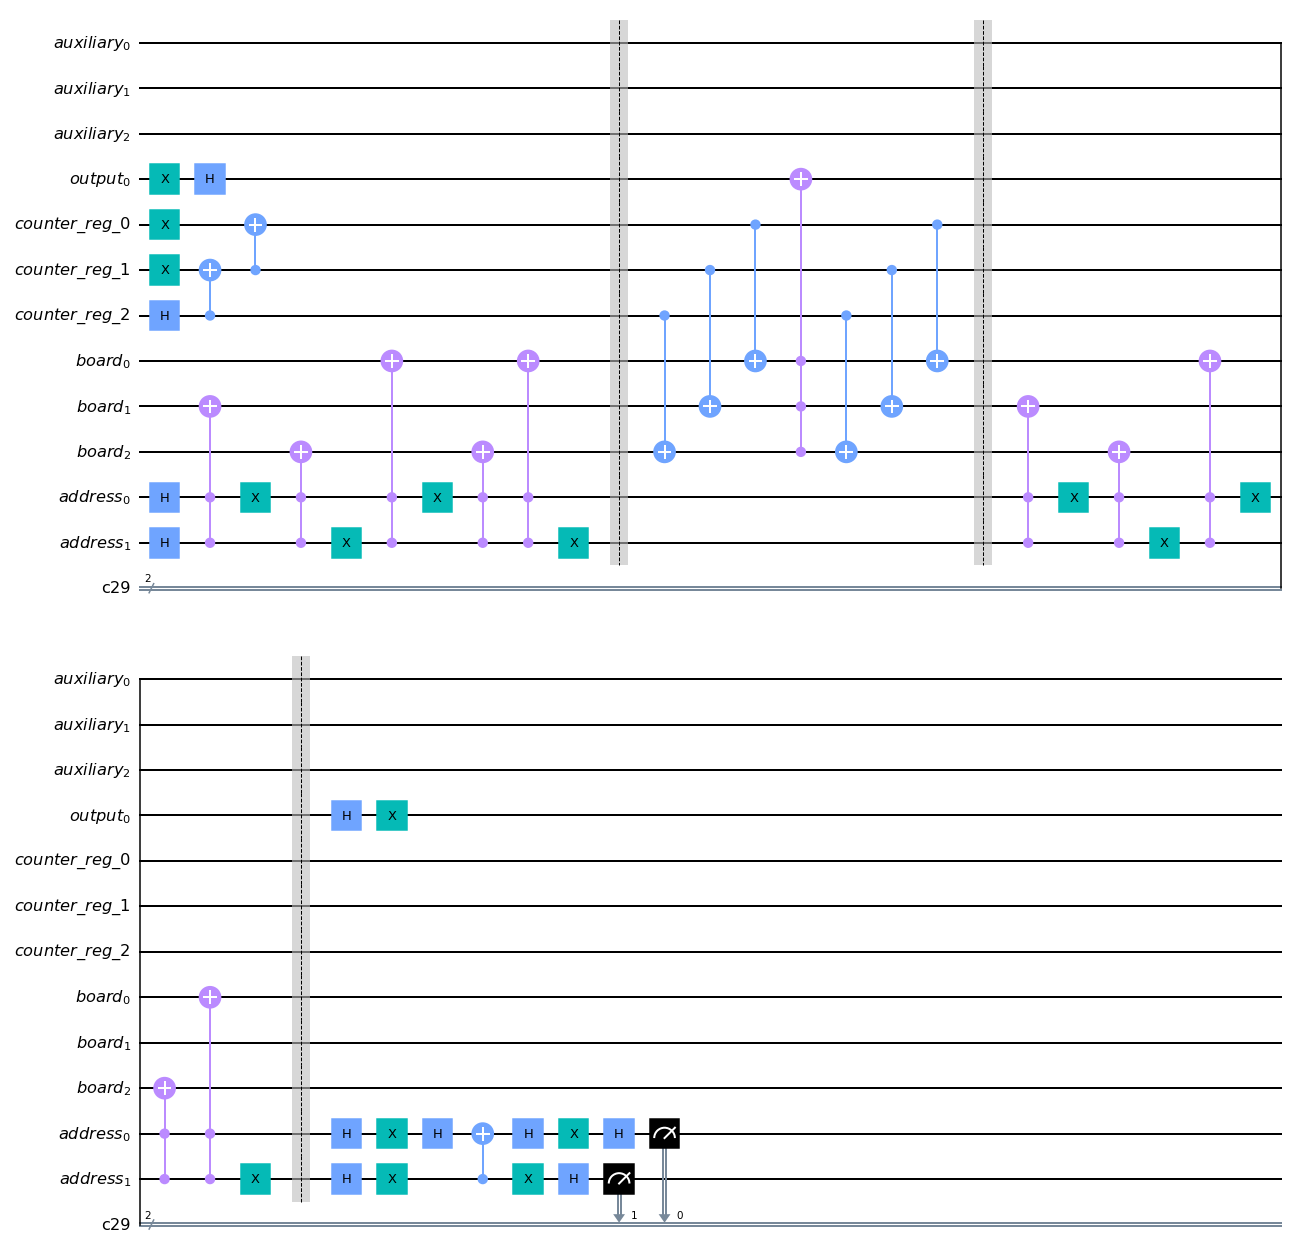

In [211]:

address = QuantumRegister(address_size, 'address')
board = QuantumRegister(bitstring_length, 'board')
counter_reg = QuantumRegister(bitstring_length, 'counter_reg')
output = QuantumRegister(1, 'output')
auxiliary = QuantumRegister(3, 'auxiliary')
result = ClassicalRegister(address_size)

qc = QuantumCircuit(address, board, counter_reg, output, auxiliary, result)

#initialize
qc.h(address[:])
qc.x(output)
qc.h(output)


#CPreare a superposition of acceptable states in counter_reg (i.e. with alternating bits)
qc.h(counter_reg[0])
for k in range(bitstring_length-1):
    qc.x(counter_reg[k+1])
    qc.cx(counter_reg[k],counter_reg[k+1])

""" 
Optimum number of iterations. Having more iterations doesn't necessarily mean better result. Accuracy was found periodic as expected.In case of 
4 data elements having 2 iterations resets the result as the solution vetor overshots the desired state. .
"""
num_of_iteration = int((np.pi/4)*(input_size**0.5))
print("Iterations : ",num_of_iteration )


# Grover iteration
for i in range(num_of_iteration):
    qram(qc, problem_set, address, board, auxiliary,address_size,input_size,bitstring_length)
    qc.barrier()
    
    oracle(qc, board, counter_reg, output, auxiliary,address_size,input_size,bitstring_length)
    qc.barrier()

    qram(qc, problem_set, address, board, auxiliary,address_size,input_size,bitstring_length)
    qc.barrier()
    
    
    
    
    # Call diffusion
    diffusion(qc, address, auxiliary)
    
qc.h(output)
qc.x(output)

    
    
    
    

        
    

qc.measure(address, result)
qc = qc.reverse_bits()

qc.draw('mpl')


In [214]:


provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=backend, shots=8192, seed_simulator=12345, backend_options={"fusion_enable":True})

result = job.result()
counts = result.get_counts()
# The following code is just to align the execution result.

ibmqfactory.load_account:WARNING:2021-09-27 16:24:42,903: Credentials are already in use. The existing account in the session will be replaced.


{'01': 4093, '11': 4099}


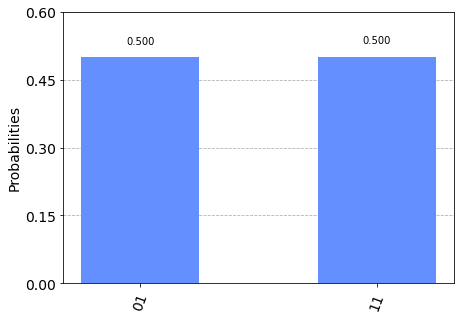

In [215]:
print(counts)
plot_histogram(counts)